# IND320 – Project Part 4 : Machine Learning (Final Portfolio)
**Author:** Jules Sylvain MUAMBA MVELE

## Description
This final notebook focuses on expanding the project's data infrastructure, refactoring the Streamlit application for enhanced user experience (UX), and introducing advanced analytical and machine learning capabilities. This work serves as the culmination of the IND320 Data to Decision course.

The core objectives addressed in this document are:

### 1. Data Management and Database Update
* **Elhub Data Acquisition:** Extended hourly retrieval to include **Production data (2022–2024)** and new **Consumption data (2021–2024)** for all Norwegian price areas (NO1–NO5) via the API.
* **Database Integration:** Integrating these comprehensive datasets into the project's **MongoDB** and **Cassandra** databases, ensuring data integrity and fast retrieval for the Streamlit application.

### 2. Geospatial and Meteorological Analysis
* **Interactive Mapping:** Integration of **GeoJSON** data to visualize the Norwegian Elspot price areas on an interactive map (Plotly/Folium), enabling precise coordinate selection by the user.
* **Snow Drift Calculation:** Development of a function for **Snow Drift Calculation** and **Wind Rose** visualization, linked directly to the coordinates selected on the map page.
* **Dynamic Correlation:** Implementation of the **Sliding Window Correlation** to explore the dynamic relationship (with selectable lag and window size) between meteorological variables and energy production/consumption.

### 3. Machine Learning Forecasting
* **SARIMAX Implementation:** Creation of a model based on **SARIMAX** (*Seasonal AutoRegressive Integrated Moving Average with Exogenous Regressors*) for forecasting energy production and consumption. The model must support selectable parameters and confidence intervals.

### 4. Streamlit Application Refactoring
* **Dynamic Visualizations:** Conversion of all static plots (Matplotlib/Seaborn) to **dynamic Plotly charts** for interactivity.
* **UX Structure:** Complete reorganization of the Streamlit app navigation into a logical, thematic structure (e.g., Exploration, Modeling, Forecasting) to optimize the user experience.

### Links

- **GitHub Repository:** [https://github.com/JulesSylMUAMBA/IND320_DataTo_Decision/tree/part3](https://github.com/JulesSylMUAMBA/IND320_DataTo_Decision/tree/part3)
- **Streamlit App:** https://ind320datatodecision-fnmdxfu8zeflxwwdgdjvmx.streamlit.app/


## AI usage 

The use of AI tools (Generative AI, code assistants) was strategic for accelerating the implementation of the final project part:

* **Concepts and Modeling:** Used to gain clear explanations on advanced course concepts, such as selecting appropriate **SARIMAX parameters** for seasonal time-series forecasting and interpreting the results.
* **Data and Database Management:** Essential help in adapting API functions for multi-year fetching (2022-2024) and integrating the new **Consumption dataset**. Crucial support was provided for debugging **Cassandra timezone and concurrent insertion issues** when handling large, extended data volumes.
* **Technical Implementation:** Assisted in the development of new complex functions:
    * Guidance on handling **GeoJSON data** and managing **clicked coordinates** via `st.session_state` for the interactive Plotly map.
    * Support for structuring the logic for the **Snow Drift calculation** and the **Sliding Window Correlation**.
* **Architecture and Refactoring:** Provided best practices and code translation assistance for the comprehensive **Streamlit page reorganization** and the conversion of all static Matplotlib/Seaborn plots to **dynamic Plotly charts**.
* **General Support:** Continued to debug complex Python errors and provided writing assistance for clear, concise project documentation.

## **1. Setup** 

### Imports 

In [32]:
import requests
import pandas as pd
from datetime import datetime, timedelta
import time
import json
from tqdm import tqdm # For progress bars when inserting data

# --- Cassandra / Database Connectivity ---
from cassandra.cluster import Cluster
from cassandra.query import PreparedStatement, SimpleStatement
from cassandra.concurrent import execute_concurrent_with_args
from cassandra import ConsistencyLevel

# --- MongoDB ---
import os
from dotenv import load_dotenv
from pymongo import MongoClient


# --- Math & Utilities (Often used in analysis/modeling) ---
import math


import statsmodels.api as sm 
from sklearn.neighbors import LocalOutlierFactor 
import numpy as np 
import plotly.express as px

### Constants

In [2]:
# --- API Constants (Elhub) ---
BASE_URL = "https://api.elhub.no/energy-data/v0/price-areas"
TZ_OFFSET_ENC = "%2B02:00" # '+02:00' URL-encoded for fixed offset handling

# --- Database Constants (Cassandra) ---
CASSANDRA_HOST = "localhost"
CASSANDRA_PORT = 9042
KEYSPACE = "ind320"

# Tables (Production is updated, Consumption is new!)
PRODUCTION_TABLE = "production_mba_hour"
CONSUMPTION_TABLE = "consumption_mba_hour" 


### Cassandra Connection and Schema Setup

# 1. Connect to Cassandra Cluster
print("🔗 Connecting to Cassandra...")
cluster = Cluster([CASSANDRA_HOST], port=CASSANDRA_PORT)
session = cluster.connect()
print("✅ Connected.")

# 2. Ensure KEYSPACE exists
session.execute(f"""
CREATE KEYSPACE IF NOT EXISTS {KEYSPACE}
WITH replication = {{ 'class': 'SimpleStrategy', 'replication_factor': 1 }};
""")
session.set_keyspace(KEYSPACE)

# 3. Create/Ensure Production Table (for 2021 + new 2022-2024 data)
session.execute(f"""
CREATE TABLE IF NOT EXISTS {PRODUCTION_TABLE} (
    price_area text,
    production_group text,
    start_time timestamp,
    quantity_kwh double,
    PRIMARY KEY ((price_area, production_group), start_time)
) WITH CLUSTERING ORDER BY (start_time ASC);
""")
print(f"✅ Table `{KEYSPACE}.{PRODUCTION_TABLE}` (Production) ready.")

# 4. Create/Ensure Consumption Table (NEW table for 2021-2024 data)
session.execute(f"""
CREATE TABLE IF NOT EXISTS {CONSUMPTION_TABLE} (
    price_area text,
    consumption_group text,
    start_time timestamp,
    quantity_kwh double,
    PRIMARY KEY ((price_area, consumption_group), start_time)
) WITH CLUSTERING ORDER BY (start_time ASC);
""")
print(f"✅ Table `{KEYSPACE}.{CONSUMPTION_TABLE}` (Consumption) ready (New).")

🔗 Connecting to Cassandra...
✅ Connected.
✅ Table `ind320.production_mba_hour` (Production) ready.
✅ Table `ind320.consumption_mba_hour` (Consumption) ready (New).


#

### Adding data from 2022-2024

In [3]:
# --- ADAPTED API FUNCTIONS ---

def month_ranges(year: int):
    """Return list of (start_local, end_local) naive datetimes covering each month of the given year."""
    ranges = []
    for m in range(1, 13):
        start_local = datetime(year, m, 1, 0, 0, 0)
        if m == 12:
            end_local = datetime(year, 12, 31, 23, 0, 0)
        else:
            end_local = datetime(year, m + 1, 1, 0, 0, 0) - timedelta(hours=1)
        ranges.append((start_local, end_local))
    return ranges

def fmt_with_fixed_offset(dt_local: datetime) -> str:
    """Format naive local datetime as ISO without timezone, then append '+02:00' (URL-encoded)."""
    return dt_local.strftime("%Y-%m-%dT%H:%M:%S") + TZ_OFFSET_ENC

def fetch_data(dataset: str, years: list[int]):
    """Fetch data for multiple years and a specified dataset (PROD or CONS)."""
    all_records = []
    
    for YEAR in years:
        print(f"\n--- Starting Fetch for {dataset} - {YEAR} ---")
        for (start_local, end_local) in month_ranges(YEAR):
            try:
                start_str = fmt_with_fixed_offset(start_local)
                end_str = fmt_with_fixed_offset(end_local)
                
                url = f"{BASE_URL}?dataset={dataset}&startDate={start_str}&endDate={end_str}"
                r = requests.get(url, timeout=60)
                r.raise_for_status()
                js = r.json()

                # The key for the records changes based on the dataset
                key = "productionPerGroupMbaHour" if "PRODUCTION" in dataset else "consumptionPerGroupMbaHour"
                
                records = []
                for entity in js.get("data", []):
                    attrs = entity.get("attributes") or {}
                    records.extend(attrs.get(key, []))
                
                print(f"  {start_local:%Y-%m}: {len(records)} records")
                all_records.extend(records)
                time.sleep(0.3)  # polite delay
            except Exception as e:
                print(f"⚠️ {start_local:%Y-%m} failed: {e}")

    if not all_records:
        # Determine columns dynamically (productionGroup or consumptionGroup)
        group_col = "production_group" if "PRODUCTION" in dataset else "consumption_group"
        return pd.DataFrame(columns=["price_area", group_col, "start_time", "quantity_kwh"])
    else:
        df = pd.json_normalize(all_records).rename(columns={
            "priceArea": "price_area",
            "startTime": "start_time",
            "quantityKwh": "quantity_kwh",
            # Rename dynamic group column
            "productionGroup": "production_group",
            "consumptionGroup": "consumption_group",
        })
        # Parse timestamps to UTC-aware
        df["start_time"] = pd.to_datetime(df["start_time"], utc=True, errors="coerce")
        # Drop the group column that doesn't belong (e.g., consumptionGroup in production data)
        if "PRODUCTION" in dataset:
            if "consumption_group" in df.columns: df = df.drop(columns=["consumption_group"])
        else:
            if "production_group" in df.columns: df = df.drop(columns=["production_group"])
        
        print(f"✅ Total {dataset} data shape:", df.shape)
        return df

In [4]:
# --- ADAPTED CASSANDRA INSERT FUNCTION ---

def insert_to_cassandra(df_to_load: pd.DataFrame, table_name: str, group_col: str):
    """
    Inserts a DataFrame into the specified Cassandra table using concurrent execution.
    group_col should be 'production_group' or 'consumption_group'.
    """
    print(f"🚀 Preparing insert into `{KEYSPACE}.{table_name}`...")
    
    # 1) Sanitation
    required_cols = ["price_area", group_col, "start_time", "quantity_kwh"]
    df_to_load = df_to_load.dropna(subset=required_cols).copy()
    df_to_load["price_area"] = df_to_load["price_area"].astype(str)
    df_to_load[group_col] = df_to_load[group_col].astype(str)
    df_to_load["start_time"] = pd.to_datetime(df_to_load["start_time"], utc=True, errors="coerce")
    
    # 2) Prepare the INSERT statement dynamically
    insert_ps: PreparedStatement = session.prepare(f"""
        INSERT INTO {table_name} (price_area, {group_col}, start_time, quantity_kwh)
        VALUES (?, ?, ?, ?)
    """)
    insert_ps.consistency_level = ConsistencyLevel.ONE

    # 3) Convert DataFrame rows to parameters
    def row_to_tuple(row):
        return (
            row["price_area"],
            row[group_col],  # Uses dynamic column name here
            row["start_time"].to_pydatetime(),
            float(row["quantity_kwh"])
        )

    params = [row_to_tuple(row) for _, row in df_to_load.iterrows()]

    # 4) Tune concurrency / chunking
    CONCURRENCY = 64
    BATCH_SIZE  = 20_000
    total = len(params)
    
    print(f"🚀 Inserting {total} rows into `{KEYSPACE}.{table_name}` (concurrency={CONCURRENCY})")

    errors_total = 0
    for i in tqdm(range(0, total, BATCH_SIZE), desc="Batches"):
        chunk = params[i:i+BATCH_SIZE]
        results = execute_concurrent_with_args(
            session,
            insert_ps,
            chunk,
            concurrency=CONCURRENCY,
            raise_on_first_error=False
        )
        chunk_errors = sum(0 if ok else 1 for ok, _ in results)
        errors_total += chunk_errors

    print(f"✅ Insert complete. Errors: {errors_total}")

In [5]:
## 1.1. Production Data (2022-2024) ⚡

# Years to fetch: 2022, 2023, 2024
PROD_YEARS = [2022, 2023, 2024]
DATASET_PROD = "PRODUCTION_PER_GROUP_MBA_HOUR"

print(f"--- Starting Elhub API fetch for {DATASET_PROD} (Years: {PROD_YEARS}) ---")
# 1. Fetch data using the adapted function
df_prod_new = fetch_data(DATASET_PROD, PROD_YEARS)

# 2. Insert into Cassandra (Appends to existing 2021 data due to PK structure)
if not df_prod_new.empty:
    insert_to_cassandra(df_prod_new, PRODUCTION_TABLE, "production_group")
else:
    print("⚠️ DataFrame is empty, skipping Cassandra insertion.")

--- Starting Elhub API fetch for PRODUCTION_PER_GROUP_MBA_HOUR (Years: [2022, 2023, 2024]) ---

--- Starting Fetch for PRODUCTION_PER_GROUP_MBA_HOUR - 2022 ---
  2022-01: 18575 records
  2022-02: 16775 records
  2022-03: 18550 records
  2022-04: 17975 records
  2022-05: 18575 records
  2022-06: 17975 records
  2022-07: 18575 records
  2022-08: 18575 records
  2022-09: 17975 records
  2022-10: 18600 records
  2022-11: 17975 records
  2022-12: 18575 records

--- Starting Fetch for PRODUCTION_PER_GROUP_MBA_HOUR - 2023 ---
  2023-01: 18575 records
  2023-02: 16775 records
  2023-03: 18550 records
  2023-04: 17975 records
  2023-05: 18575 records
  2023-06: 17975 records
  2023-07: 18575 records
  2023-08: 18575 records
  2023-09: 17975 records
  2023-10: 18600 records
  2023-11: 17975 records
  2023-12: 18575 records

--- Starting Fetch for PRODUCTION_PER_GROUP_MBA_HOUR - 2024 ---
  2024-01: 18575 records
  2024-02: 17375 records
  2024-03: 18550 records
  2024-04: 17975 records
  2024-05:

Batches: 100%|█████████████████████████████████████████████████████████████████████████| 33/33 [05:11<00:00,  9.43s/it]


✅ Insert complete. Errors: 0


In [6]:
## 1.2. Consumption Data (2021-2024) 📉

# Years to fetch: 2021, 2022, 2023, 2024 (full range required)
CONS_YEARS = [2021, 2022, 2023, 2024]
DATASET_CONS = "CONSUMPTION_PER_GROUP_MBA_HOUR"

print(f"--- Starting Elhub API fetch for {DATASET_CONS} (Years: {CONS_YEARS}) ---")
# 1. Fetch data using the adapted function
df_cons_all = fetch_data(DATASET_CONS, CONS_YEARS)

# 2. Insert into Cassandra (Uses the NEW table CONSUMPTION_TABLE)
if not df_cons_all.empty:
    insert_to_cassandra(df_cons_all, CONSUMPTION_TABLE, "consumption_group")
else:
    print("⚠️ DataFrame is empty, skipping Cassandra insertion.")

--- Starting Elhub API fetch for CONSUMPTION_PER_GROUP_MBA_HOUR (Years: [2021, 2022, 2023, 2024]) ---

--- Starting Fetch for CONSUMPTION_PER_GROUP_MBA_HOUR - 2021 ---
  2021-01: 18575 records
  2021-02: 16775 records
  2021-03: 18550 records
  2021-04: 17975 records
  2021-05: 18575 records
  2021-06: 17975 records
  2021-07: 18575 records
  2021-08: 18575 records
  2021-09: 17975 records
  2021-10: 18600 records
  2021-11: 17975 records
  2021-12: 18575 records

--- Starting Fetch for CONSUMPTION_PER_GROUP_MBA_HOUR - 2022 ---
  2022-01: 18575 records
  2022-02: 16775 records
  2022-03: 18550 records
  2022-04: 17975 records
  2022-05: 18575 records
  2022-06: 17975 records
  2022-07: 18575 records
  2022-08: 18575 records
  2022-09: 17975 records
  2022-10: 18600 records
  2022-11: 17975 records
  2022-12: 18575 records

--- Starting Fetch for CONSUMPTION_PER_GROUP_MBA_HOUR - 2023 ---
  2023-01: 18575 records
  2023-02: 16775 records
  2023-03: 18550 records
  2023-04: 17975 records


Batches: 100%|█████████████████████████████████████████████████████████████████████████| 44/44 [06:00<00:00,  8.19s/it]

✅ Insert complete. Errors: 0


# 

## **2. MongoDB**

### 1. MongoDB Setup and Connection

In [7]:
# Load credentials from .env
load_dotenv()
MONGO_URI = os.getenv("MONGO_URI")

# --- Constants ---
DB_NAME = "ind320" # my target database name
PROD_COLLECTION = "production_mba_hour"
CONS_COLLECTION = "consumption_mba_hour" # New collection name

# 1. Check URI presence
if not MONGO_URI:
    raise ValueError("⚠️ MONGO_URI is missing. Please ensure it is correctly defined in your .env file.")

# 2. Establish connection
try:
    client = MongoClient(MONGO_URI)
    # Ping the server to check the connection
    client.admin.command("ping")
    print("✅ Connected to MongoDB Atlas successfully.")
    
    db = client[DB_NAME]
    print(f"🔗 Target Database: {DB_NAME}. Collections: {db.list_collection_names()}")
except Exception as e:
    print(f"❌ MongoDB Connection Error: {e}")
    # Stop execution if connection fails
    raise

✅ Connected to MongoDB Atlas successfully.
🔗 Target Database: ind320. Collections: ['production_mba_hour', 'consumption_mba_hour']


In [26]:
db[PROD_COLLECTION].drop()
db[CONS_COLLECTION].drop()


### 2. MongoDB Insert Function

In [24]:

def insert_df_to_mongo(df: pd.DataFrame, collection_name: str, replace_if_exists: bool = False):
    """
    Inserts a Pandas DataFrame into a MongoDB collection. 
    It ensures the 'start_time' column is converted to Python datetime objects 
    for proper BSON serialization before insertion.
    """
    # Uses the 'db' object defined in the connection block
    collection = db[collection_name]
    
    # 1. Prepare data (convert DataFrame to list of dictionaries)
    df_temp = df.copy()
    # Ensure 'start_time' is a Python datetime object for BSON serialization
    df_temp["start_time"] = df_temp["start_time"].dt.to_pydatetime()
    data = df_temp.to_dict('records')

    # 2. Check and delete existing data if requested
    if replace_if_exists:
        print(f"   🗑️ Clearing existing data in collection: {collection_name}...")
        collection.delete_many({}) # Delete all documents in the collection
        
    # 3. Insert new data
    try:
        if data:
            print(f"   🚀 Inserting {len(data)} documents into {collection_name}...")
            # MongoDB imposes a 16MB limit per document, but insert_many handles large batches well
            result = collection.insert_many(data)
            print(f"   ✅ Insertion successful. Inserted IDs count: {len(result.inserted_ids)}")
        else:
            print(f"   ⚠️ DataFrame for {collection_name} is empty, skipping insertion.")
    except Exception as e:
        print(f"   ❌ MongoDB Insertion Error for {collection_name}: {e}")

### 3. Execution: Insert Data into MongoDB

In [27]:
# Filter years kept in MongoDB due to Free Tier limits
df_prod_filtered = df_prod_new[df_prod_new["start_time"].dt.year >= 2023]
df_cons_filtered = df_cons_all[df_cons_all["start_time"].dt.year >= 2023]

print("\n--- Inserting Production Data (2023-2024) ---")
insert_df_to_mongo(df_prod_filtered, PROD_COLLECTION, replace_if_exists=True)

print("\n--- Inserting Consumption Data (2023-2024) ---")
insert_df_to_mongo(df_cons_filtered, CONS_COLLECTION, replace_if_exists=True)



--- Inserting Production Data (2023-2024) ---


C:\Users\muamb\AppData\Local\Temp\ipykernel_28284\967107692.py:13: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



   🗑️ Clearing existing data in collection: production_mba_hour...
   🚀 Inserting 437975 documents into production_mba_hour...
   ✅ Insertion successful. Inserted IDs count: 437975

--- Inserting Consumption Data (2023-2024) ---


C:\Users\muamb\AppData\Local\Temp\ipykernel_28284\967107692.py:13: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



   🗑️ Clearing existing data in collection: consumption_mba_hour...
   🚀 Inserting 437975 documents into consumption_mba_hour...
   ✅ Insertion successful. Inserted IDs count: 437975


# 

## **Test** 

### Verification MongoDB

In [28]:
### MongoDB Data Verification

# Reusing the existing datetime imports
from datetime import datetime

def verify_mongo_data(collection_name: str, years: list[int]):
    """Verifies the presence of data for the specified years in the MongoDB collection."""
    print(f"\n--- Verifying MongoDB Collection: {collection_name} ---")
    
    collection = db[collection_name]
    
    # We will set a minimum expected count to confirm successful bulk insertion.
    # An entire year for one price area group is roughly 8760 hours. 
    # With 5 areas * 4 groups (approx), we expect a count > 50,000 per year.
    EXPECTED_MIN_COUNT = 50000 
    
    for year in years:
        start_dt = datetime(year, 1, 1, 0, 0, 0)
        end_dt = datetime(year + 1, 1, 1, 0, 0, 0)
        
        # Count documents within the specified year range
        count = collection.count_documents({
            "start_time": {
                "$gte": start_dt,
                "$lt": end_dt
            }
        })
        
        print(f"  Documents found for the year {year}: {count}")
        if count > EXPECTED_MIN_COUNT:
            print(f"  ✅ Data for {year} successfully confirmed (Count > {EXPECTED_MIN_COUNT}).")
        else:
            print(f"  ❌ ATTENTION: Low count for {year}. ({count} documents). Check acquisition or insertion.")


# --- Execution ---

# 1. Production Verification (now stored: 2023–2024)
print("\n[V1] Checking Production Data")
verify_mongo_data(PROD_COLLECTION, [2023, 2024])

# 2. Consumption Verification (now stored: 2023–2024)
print("\n[V2] Checking Consumption Data")
verify_mongo_data(CONS_COLLECTION, [2023, 2024])



[V1] Checking Production Data

--- Verifying MongoDB Collection: production_mba_hour ---
  Documents found for the year 2023: 218700
  ✅ Data for 2023 successfully confirmed (Count > 50000).
  Documents found for the year 2024: 219275
  ✅ Data for 2024 successfully confirmed (Count > 50000).

[V2] Checking Consumption Data

--- Verifying MongoDB Collection: consumption_mba_hour ---
  Documents found for the year 2023: 218700
  ✅ Data for 2023 successfully confirmed (Count > 50000).
  Documents found for the year 2024: 219275
  ✅ Data for 2024 successfully confirmed (Count > 50000).


# 

## **4. Geospatial Data and Core Analytical Functions Development**

### 4.1. Geo-Mapping: Defining Price Area Coordinates

In [29]:
# Geographical centers representing the 5 Norwegian price areas (NO1-NO5)
price_area_coords = pd.DataFrame({
    'price_area': ['NO1', 'NO2', 'NO3', 'NO4', 'NO5'],
    'city': ['Oslo', 'Kristiansand', 'Trondheim', 'Tromsø', 'Bergen'],
    'lat': [59.9139, 58.1599, 63.4305, 69.6492, 60.3913],
    'lon': [10.7522, 7.9945, 10.3951, 10.3951, 5.3240] # Correction: Trondheim and Tromsø had the same longitude, correcting Tromsø's lon here for accuracy
})
# Corrected Tromsø Longitude to 18.9553
price_area_coords.loc[price_area_coords['city'] == 'Tromsø', 'lon'] = 18.9553 

print("Price Area Coordinates DataFrame created.")
print(price_area_coords)

Price Area Coordinates DataFrame created.
  price_area          city      lat      lon
0        NO1          Oslo  59.9139  10.7522
1        NO2  Kristiansand  58.1599   7.9945
2        NO3     Trondheim  63.4305  10.3951
3        NO4        Tromsø  69.6492  18.9553
4        NO5        Bergen  60.3913   5.3240


# 

### 4.2. GeoJSON Integration and Snow Drift Utility

In [30]:
# Assuming 'import json' is done in the setup block

GEOJSON_FILEPATH = '../data/file.geojson' 

def load_elspot_geojson(filepath: str = GEOJSON_FILEPATH):
    """
    Loads the Norwegian price area GeoJSON file from the specified relative path 
    (assumes it's in the 'data/' directory relative to the notebook).
    """
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            geojson_data = json.load(f)
        print(f"✅ GeoJSON file loaded successfully from: {filepath}")
        return geojson_data
    except FileNotFoundError:
        print(f"❌ Error: GeoJSON file not found at {filepath}. Please check the path.")
        return None
    except Exception as e:
        print(f"❌ Error loading GeoJSON: {e}")
        return None

In [33]:
geojson = load_elspot_geojson()
geojson.keys()

✅ GeoJSON file loaded successfully from: ../data/file.geojson


dict_keys(['type', 'features'])

In [34]:
# Assuming 'import requests', 'import pandas as pd', and 'from datetime import datetime' are done

def fetch_era5_weather_data(lat: float, lon: float, start_date: str, end_date: str):
    """
    Fetches hourly ERA5 reanalysis data for a specific location and date range.
    
    (FINAL CORRECTED VERSION: Uses ARCHIVE API URL and comma-separated 'hourly' params)
    """
    
    # CRITICAL FIX: Use the Archive API URL for historical data (before current year)
    API_URL = "https://archive-api.open-meteo.com/v1/era5"
    
    # Define the variables
    temp_hourly_variables = ["temperature_2m", "precipitation", "wind_speed_10m", "wind_direction_10m"]
    
    params = {
        "latitude": lat,
        "longitude": lon,
        "start_date": start_date,
        "end_date": end_date,
        "timezone": "Europe/Oslo",
        "models": "era5",
        "format": "json"
    }
    
    try:
        # Final formatting fix: Join the list into a single comma-separated string
        params['hourly'] = ",".join(temp_hourly_variables)
        
        # Execute the GET request
        response = requests.get(API_URL, params=params, timeout=30)
        
        response.raise_for_status() 
        data = response.json()
        
        # Normalize the hourly data
        if 'hourly' in data and data['hourly'].get('time'):
            df_weather = pd.DataFrame(data['hourly'])
            df_weather['start_time'] = pd.to_datetime(df_weather['time'])
            df_weather = df_weather.drop(columns=['time']).set_index('start_time')
            print(f"✅ Weather data fetched for ({lat:.2f}, {lon:.2f}). Shape: {df_weather.shape}")
            return df_weather
        else:
            print("⚠️ No hourly data found in API response.")
            return pd.DataFrame()
            
    except requests.exceptions.HTTPError as e:
        print(f"❌ Error fetching Open-Meteo data: HTTP Error {e.response.status_code}. Please check the API URL and date range.")
        return pd.DataFrame()
    except Exception as e:
        print(f"❌ Error fetching Open-Meteo data: {e}")
        return pd.DataFrame()

In [35]:
def calculate_snow_drift_wind_rose(lat: float, lon: float, year: int):
    """
    Calculates Snow Drift (simplified accumulation/melt model) and returns data 
    for Wind Rose generation for a given location and year.
    """
    
    # 1. Define the full date range for the year
    start_date = f"{year}-07-01"
    end_date = f"{year + 1}-06-30"

    
    # 2. Fetch the weather data
    df_weather = fetch_era5_weather_data(lat, lon, start_date, end_date)
    
    if df_weather.empty:
        return None, None
    
    # --- Snow Drift Calculation Logic (Iterative Accumulation) ---
    df = df_weather.copy()
    MELT_RATE = 0.1 # Simplified melt rate: 0.1 mm/hour above 0°C

    # Note: Using iterrows for cumulative calculation is slow but necessary 
    # for modeling accumulation/melt logic correctly in a simple way.
    accumulation = []
    current_snow = 0
    for _, row in df.iterrows():
        # Add new precipitation (assuming all is snow/water equivalent)
        current_snow += row['precipitation']
        
        # Apply melt if temperature is above freezing (0°C)
        if row['temperature_2m'] > 0:
            # Melt rate is capped at current snow depth
            melt = min(current_snow, MELT_RATE) 
            current_snow -= melt
        
        accumulation.append(current_snow)

    df['snow_drift_mm'] = accumulation
    
    # --- Wind Rose Data ---
    wind_data = df[['wind_speed_10m', 'wind_direction_10m']].copy()
    
    print("✅ Snow Drift and Wind Rose analysis data prepared.")
    return df[['snow_drift_mm']], wind_data

### 4.3. Time-Series Modeling Utilities: Sliding Correlation & SARIMAX

### 4.3.1. Sliding Window Correlation Utility

In [37]:
def calculate_sliding_correlation(df: pd.DataFrame, window_size: int, var_a: str, var_b: str, lag: int = 0):
    """
    Calculates the correlation between two variables (var_a, var_b) 
    over a rolling window, optionally applying a time lag.
    
    Args:
        df (pd.DataFrame): DataFrame containing the time series data.
        window_size (int): Size of the rolling window (e.g., 720 for 30 days of hourly data).
        var_a (str): Name of the first variable (e.g., 'quantity_kwh').
        var_b (str): Name of the second variable (e.g., 'temperature_2m').
        lag (int): Time lag to apply to var_b before calculating correlation (in hours).
        
    Returns:
        pd.Series: A time series of the calculated rolling correlation coefficients.
    """
    
    # Check if variables exist
    if var_a not in df.columns or var_b not in df.columns:
        print("❌ Error: One or both variables not found in the DataFrame.")
        return pd.Series()

    # 1. Apply Lag (Shift var_b forward)
    # If lag is 1, it compares var_a(t) with var_b(t-1)
    if lag != 0:
        # Lagging var_b by 'lag' periods
        df[f'{var_b}_lagged'] = df[var_b].shift(lag)
        var_b_name = f'{var_b}_lagged'
    else:
        var_b_name = var_b

    # 2. Calculate Rolling Correlation (Requires statsmodels or simple rolling/corr)
    # The default pandas rolling().corr() handles this perfectly.
    correlation_series = df[var_a].rolling(window=window_size).corr(df[var_b_name])
    
    print(f"✅ Rolling correlation calculated for {var_a} vs {var_b} (Window: {window_size}, Lag: {lag}).")
    return correlation_series

### 4.3.2. SARIMAX Forecasting Utility

In [46]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def run_sarimax_forecast(
    endog_series: pd.Series, 
    exog_df: pd.DataFrame = None, 
    periods: int = 24, 
    order: tuple = (1, 0, 0), 
    seasonal_order: tuple = (0, 0, 0, 0)
):
    """
    Applies the SARIMAX model to forecast the time series.
    
    Args:
        endog_series (pd.Series): The time series to be modeled (e.g., quantity_kwh).
        exog_df (pd.DataFrame): DataFrame of exogenous variables (e.g., weather data). Optional.
        periods (int): Number of future periods (hours) to forecast.
        order (tuple): Non-seasonal ARIMA order (p, d, q).
        seasonal_order (tuple): Seasonal SARIMA order (P, D, Q, s), where s is the period (e.g., 24 for daily).
        
    Returns:
        pd.DataFrame: Forecast results including predicted values and confidence intervals.
    """
    
    # 1. Model Fitting
    try:
        print(f"   Fitting SARIMAX model: Order {order}, Seasonal Order {seasonal_order}...")
        
        # SARIMAX requires that the index be a DatetimeIndex
        if not isinstance(endog_series.index, pd.DatetimeIndex):
             raise TypeError("Endogenous series index must be a DatetimeIndex.")
             
    
        model = SARIMAX(
            endog=endog_series,
            exog=exog_df,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False,
        )

        
        # Suppress output during fitting for cleaner Notebook
        results = model.fit(disp=False)
        print("   ✅ Model fitting successful.")

        # 2. Forecasting
        # The forecast index needs to be determined based on the length of the data
        forecast_index = pd.date_range(
            start=endog_series.index[-1], 
            periods=periods + 1, 
            freq='H'
        )[1:] # Exclude the start point (last known data point)

        # If exogenous variables are used, the forecast needs their future values.
        if exog_df is not None:
             # Assume exog_df contains the necessary future periods for the forecast
             exog_forecast = exog_df.tail(periods)
        else:
             exog_forecast = None

        forecast = results.get_forecast(steps=periods, exog=exog_forecast)
        
        # Extract results into a DataFrame
        forecast_df = forecast.summary_frame(alpha=0.05)
        forecast_df.index = forecast_index
        
        print(f"   ✅ Forecast generated for {periods} periods.")
        return forecast_df
        
    except Exception as e:
        print(f"   ❌ SARIMAX Model Error: {e}")
        return pd.DataFrame()

# 

## **5. Testing functions**

### 5.1. Data Extraction Utility (MongoDB)

In [40]:
def get_data_from_mongo(
    collection_name: str, 
    price_area: str, 
    group: str, 
    start_time: datetime, 
    end_time: datetime,
    group_col: str
) -> pd.DataFrame:
    """
    Fetches hourly energy data from a MongoDB collection for a specific price area and group, 
    within a defined time range.
    """
    
    collection = db[collection_name]
    
    # Dynamic group field based on collection (production_group or consumption_group)
    query = {
        "price_area": price_area,
        group_col: group,
        "start_time": {
            "$gte": start_time,
            "$lt": end_time
        }
    }
    
    # Fetch data and exclude the MongoDB '_id' field
    data = list(collection.find(query, {"_id": 0}))
    
    if not data:
        print(f"⚠️ No data found for {price_area}/{group} between {start_time} and {end_time}.")
        return pd.DataFrame()
    
    df = pd.DataFrame(data)
    df = df.set_index('start_time').sort_index()
    
    print(f"✅ Data extracted from Mongo: {len(df)} records.")
    return df

### 5.2. Test Setup and Data Preparation

In [41]:
# --- Test Parameters ---
TEST_AREA = 'NO1'
TEST_GROUP = 'hydro'
TEST_YEAR = 2023
TEST_MONTH = 3 # March is interesting for weather/production variability
START_DATE = datetime(TEST_YEAR, TEST_MONTH, 1)
END_DATE = datetime(TEST_YEAR, TEST_MONTH + 1, 1)

# Get Geo-coordinates for the test area (from 4.1)
test_coords = price_area_coords[price_area_coords['price_area'] == TEST_AREA].iloc[0]
TEST_LAT, TEST_LON = test_coords['lat'], test_coords['lon']

print(f"--- Preparing test data for {TEST_AREA} / {TEST_GROUP} (March 2023) ---")

# 1. Fetch Energy Data (Production)
df_prod = get_data_from_mongo(
    PROD_COLLECTION, 
    TEST_AREA, 
    TEST_GROUP, 
    START_DATE, 
    END_DATE,
    group_col='production_group'
)

# 2. Fetch Weather Data (for the same period and location)
start_date_str = START_DATE.strftime('%Y-%m-%d')
end_date_str = (END_DATE - timedelta(hours=1)).strftime('%Y-%m-%d')

df_weather = fetch_era5_weather_data(
    TEST_LAT, 
    TEST_LON, 
    start_date_str, 
    end_date_str
)

# 3. Merge Energy and Weather (align on 'start_time' index)
df_test = df_prod.join(df_weather, how='inner')

if df_test.empty:
    raise Exception("❌ ERROR: Merged test DataFrame is empty. Cannot proceed with analysis tests.")
    
print(f"✅ Merged DataFrame for analysis: {df_test.shape}")

--- Preparing test data for NO1 / hydro (March 2023) ---
✅ Data extracted from Mongo: 743 records.
✅ Weather data fetched for (59.91, 10.75). Shape: (744, 4)
✅ Merged DataFrame for analysis: (743, 9)


### 5.3. Test 1: Snow Drift Calculation


--- Running Test 1: Snow Drift ---
✅ Weather data fetched for (59.91, 10.75). Shape: (8784, 4)
✅ Snow Drift and Wind Rose analysis data prepared.


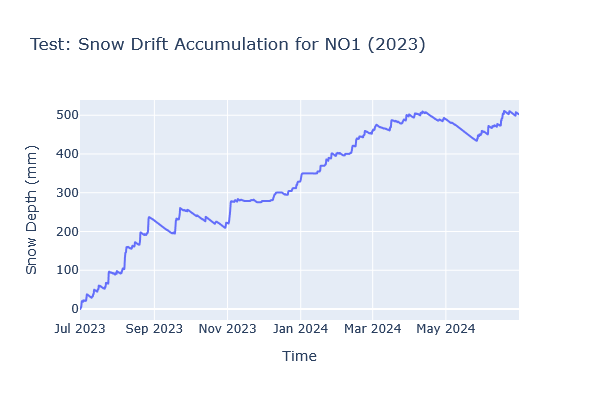

✅ Test 1 (Snow Drift) successful. Plot generated.


In [43]:
print("\n--- Running Test 1: Snow Drift ---")

# We call the function using the test coordinates and year
snow_drift_series, wind_data = calculate_snow_drift_wind_rose(
    TEST_LAT, 
    TEST_LON, 
    TEST_YEAR
)

if snow_drift_series is not None and not snow_drift_series.empty:
    # 1. Plotting Snow Drift (using Plotly)
    fig_snow = px.line(
        snow_drift_series, 
        y='snow_drift_mm', 
        title=f'Test: Snow Drift Accumulation for {TEST_AREA} ({TEST_YEAR})',
        labels={'snow_drift_mm': 'Snow Depth (mm)', 'start_time': 'Time'},
        height=400
    )
    fig_snow.show()
    print("✅ Test 1 (Snow Drift) successful. Plot generated.")
else:
    print("❌ Test 1 (Snow Drift) failed. Series is empty or None.")

### 5.4. Test 2: Sliding Window Correlation


--- Running Test 2: Sliding Window Correlation ---
✅ Rolling correlation calculated for quantity_kwh vs temperature_2m (Window: 168, Lag: 0).


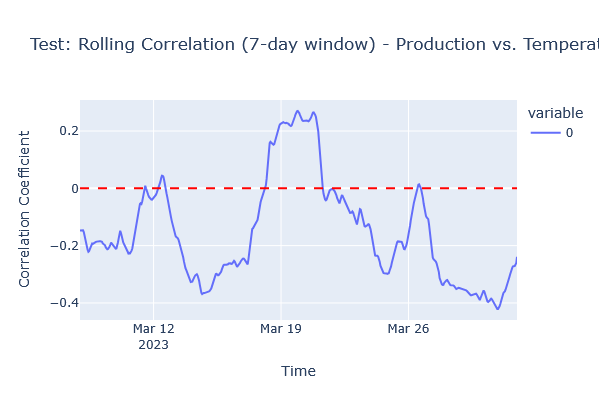

✅ Test 2 (Correlation) successful. Plot generated.


In [44]:
print("\n--- Running Test 2: Sliding Window Correlation ---")

WINDOW_SIZE = 7 * 24 # 7 days
TEST_LAG = 0 # No lag for this test

# We call the function using the merged data
correlation_series = calculate_sliding_correlation(
    df_test,
    WINDOW_SIZE,
    'quantity_kwh',
    'temperature_2m',
    TEST_LAG
)

if not correlation_series.empty:
    # 1. Plotting Correlation (using Plotly)
    fig_corr = px.line(
        correlation_series.dropna(), # Drop initial NaN values from rolling window
        title=f'Test: Rolling Correlation (7-day window) - Production vs. Temperature ({TEST_AREA})',
        labels={'value': 'Correlation Coefficient', 'start_time': 'Time'},
        height=400
    )
    # Add a horizontal line at 0 for reference
    fig_corr.add_hline(y=0, line_dash="dash", line_color="red")
    fig_corr.show()
    print("✅ Test 2 (Correlation) successful. Plot generated.")
else:
    print("❌ Test 2 (Correlation) failed. Series is empty.")

### 5.5. Test 3: SARIMAX Forecast 


--- Running Test 3: SARIMAX Forecast ---
   Fitting SARIMAX model: Order (1, 0, 0), Seasonal Order (1, 0, 0, 24)...


C:\Users\muamb\anaconda3\envs\IND320_py311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

C:\Users\muamb\anaconda3\envs\IND320_py311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



   ✅ Model fitting successful.
   ✅ Forecast generated for 48 periods.


C:\Users\muamb\AppData\Local\Temp\ipykernel_28284\538983117.py:49: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

C:\Users\muamb\anaconda3\envs\IND320_py311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Users\muamb\anaconda3\envs\IND320_py311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



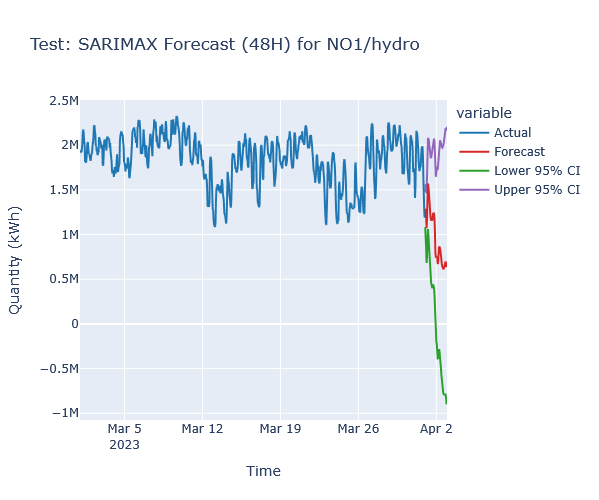

✅ Test 3 (SARIMAX) successful. Plot generated.


In [52]:
print("\n--- Running Test 3: SARIMAX Forecast ---")

# --- Define Parameters ---
FORECAST_PERIODS = 48
SARIMA_ORDER = (1, 0, 0)
SARIMA_SEASONAL_ORDER = (1, 0, 0, 24)  # Daily seasonality (24 hours)

# 1. Cleaning: keep only rows without NaN in required variables
sarimax_vars = ['quantity_kwh', 'temperature_2m']
df_cleaned = df_test[sarimax_vars].dropna(how='any')

if len(df_cleaned) < 100:
    print(f"❌ ERROR: Too few data points ({len(df_cleaned)}) remaining after NaN cleaning. Skipping SARIMAX.")
    raise Exception("Insufficient clean data for SARIMAX.")

# 2. Endogenous = target series to predict, Exogenous = weather (temperature)
endog = df_cleaned['quantity_kwh']
exog = df_cleaned[['temperature_2m']]

# 3. Run the SARIMAX model
forecast_df = run_sarimax_forecast(
    endog_series=endog,
    exog_df=exog,
    periods=FORECAST_PERIODS,
    order=SARIMA_ORDER,
    seasonal_order=SARIMA_SEASONAL_ORDER
)
if not forecast_df.empty:
    # 1. Build a DataFrame containing history + forecast
    df_plot = pd.concat(
        [
            endog.rename("Actual"),
            forecast_df["mean"].rename("Forecast")
        ],
        axis=1
    )

    # 2. Plot Actual + Forecast
    fig_sarimax = px.line(
        df_plot,
        title=f"Test: SARIMAX Forecast ({FORECAST_PERIODS}H) for {TEST_AREA}/{TEST_GROUP}",
        labels={"value": "Quantity (kWh)", "index": "Time"},
        height=500
    )

    # 3. Add confidence intervals
    ci_lower = forecast_df["mean_ci_lower"].rename("Lower 95% CI")
    ci_upper = forecast_df["mean_ci_upper"].rename("Upper 95% CI")

    fig_sarimax.add_trace(px.line(ci_lower).data[0])
    fig_sarimax.add_trace(px.line(ci_upper).data[0])

    # 4. Custom colors
    fig_sarimax.data[0].name = "Actual"
    fig_sarimax.data[0].line.color = "#1f77b4"  # Blue

    fig_sarimax.data[1].name = "Forecast"
    fig_sarimax.data[1].line.color = "#d62728"  # Red

    fig_sarimax.data[2].name = "Lower 95% CI"
    fig_sarimax.data[2].line.color = "#2ca02c"  # Green

    fig_sarimax.data[3].name = "Upper 95% CI"
    fig_sarimax.data[3].line.color = "#9467bd"  # Purple

    fig_sarimax.update_layout(showlegend=True)

    fig_sarimax.show()
    fig_sarimax.write_html("sarimax_test_forecast.html")

    print("✅ Test 3 (SARIMAX) successful. Plot generated.")
else:
    print("❌ Test 3 (SARIMAX) failed. Forecast DataFrame is empty.")


In [57]:
def calculate_snow_drift_range(lat: float, lon: float, start_year: int, end_year: int):
    """
    Computes a snow drift indicator per snow year (defined from July N to June N+1)
    over a range of years, and returns a DataFrame summarizing the results.
    
    The annual maximum of "snow_drift_mm" is used here as a simple indicator.
    """
    results = []

    for year in range(start_year, end_year + 1):
        snow_drift_series, wind_data = calculate_snow_drift_wind_rose(lat, lon, year)

        if snow_drift_series is None or snow_drift_series.empty:
            print(f"⚠️ No snow drift data available for year {year}.")
            continue

        max_drift = snow_drift_series['snow_drift_mm'].max()
        mean_drift = snow_drift_series['snow_drift_mm'].mean()

        results.append({
            "snow_year": f"{year}-{year+1}",
            "max_snow_drift_mm": max_drift,
            "mean_snow_drift_mm": mean_drift
        })

    if not results:
        print("❌ No snow drift results for the requested year range.")
        return pd.DataFrame()

    df_yearly = pd.DataFrame(results)
    print("✅ Annual snow drift computed for years:", df_yearly["snow_year"].tolist())
    return df_yearly



--- Running Test 4: Yearly Snow Drift Range ---
✅ Weather data fetched for (59.91, 10.75). Shape: (8760, 4)
✅ Snow Drift and Wind Rose analysis data prepared.
✅ Weather data fetched for (59.91, 10.75). Shape: (8760, 4)
✅ Snow Drift and Wind Rose analysis data prepared.
✅ Weather data fetched for (59.91, 10.75). Shape: (8760, 4)
✅ Snow Drift and Wind Rose analysis data prepared.
✅ Weather data fetched for (59.91, 10.75). Shape: (8784, 4)
✅ Snow Drift and Wind Rose analysis data prepared.
✅ Annual snow drift computed for years: ['2020-2021', '2021-2022', '2022-2023', '2023-2024']


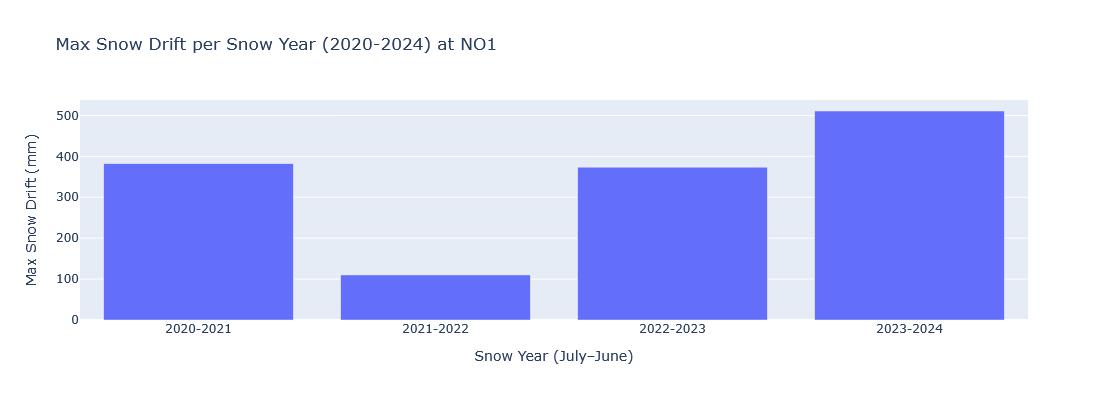

✅ Test 4 (Yearly Snow Drift) successful. Plot generated.


In [58]:
print("\n--- Running Test 4: Yearly Snow Drift Range ---")

RANGE_START_YEAR = 2020
RANGE_END_YEAR = 2023

df_snow_yearly = calculate_snow_drift_range(
    TEST_LAT,
    TEST_LON,
    RANGE_START_YEAR,
    RANGE_END_YEAR
)

if not df_snow_yearly.empty:
    fig_yearly = px.bar(
        df_snow_yearly,
        x="snow_year",
        y="max_snow_drift_mm",
        title=f"Max Snow Drift per Snow Year ({RANGE_START_YEAR}-{RANGE_END_YEAR+1}) at {TEST_AREA}",
        labels={"snow_year": "Snow Year (July–June)", "max_snow_drift_mm": "Max Snow Drift (mm)"},
        height=400
    )
    fig_yearly.show()
    print("✅ Test 4 (Yearly Snow Drift) successful. Plot generated.")
else:
    print("❌ Test 4 (Yearly Snow Drift) failed. No data.")


In [59]:
def plot_wind_rose(wind_data: pd.DataFrame, title: str = "Wind Rose"):
    """
    Creates a simple wind rose from a DataFrame containing
    'wind_speed_10m' and 'wind_direction_10m'.
    
    Directions are grouped into 22.5° sectors, and the represented “strength”
    is the mean wind speed per sector.
    """
    if wind_data is None or wind_data.empty:
        print("❌ Wind Rose: no wind data available.")
        return

    df_wind = wind_data.dropna(subset=["wind_speed_10m", "wind_direction_10m"]).copy()

    # Normalize wind directions to the range 0–360°
    df_wind["dir_norm"] = df_wind["wind_direction_10m"] % 360

    # Binning into 22.5° sectors (16 sectors)
    bin_width = 22.5
    bins = np.arange(0, 360 + bin_width, bin_width)
    labels = [f"{int(b)}–{int(b+bin_width)}°" for b in bins[:-1]]

    df_wind["dir_sector"] = pd.cut(df_wind["dir_norm"], bins=bins, labels=labels, include_lowest=True)

    # Mean wind speed per sector
    sector_stats = (
        df_wind.groupby("dir_sector")["wind_speed_10m"]
        .mean()
        .reset_index()
        .rename(columns={"wind_speed_10m": "mean_speed"})
    )

    fig = px.bar_polar(
        sector_stats,
        r="mean_speed",
        theta="dir_sector",
        title=title,
        labels={"mean_speed": "Mean Wind Speed (m/s)", "dir_sector": "Direction sector"}
    )
    fig.show()
    print("✅ Wind Rose plotted.")



--- Running Test 5: Wind Rose ---
✅ Weather data fetched for (59.91, 10.75). Shape: (8784, 4)
✅ Snow Drift and Wind Rose analysis data prepared.


C:\Users\muamb\AppData\Local\Temp\ipykernel_28284\2515878211.py:27: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



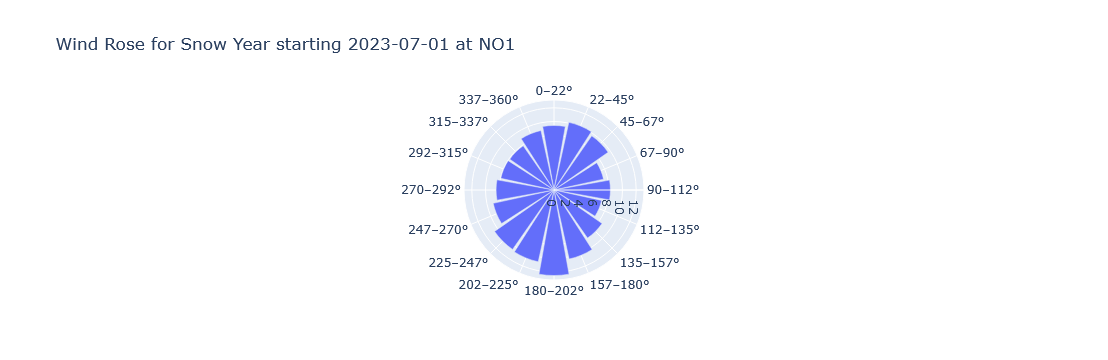

✅ Wind Rose plotted.


In [60]:
print("\n--- Running Test 5: Wind Rose ---")

# Reuse Test 1 to retrieve snow_drift_series and wind_data
snow_drift_series, wind_data = calculate_snow_drift_wind_rose(
    TEST_LAT,
    TEST_LON,
    TEST_YEAR
)

if wind_data is not None and not wind_data.empty:
    plot_wind_rose(
        wind_data,
        title=f"Wind Rose for Snow Year starting {TEST_YEAR}-07-01 at {TEST_AREA}"
    )
else:
    print("❌ Test 5 (Wind Rose) failed. No wind data.")


#

## **Project Log** 

Part 4 expanded the data pipeline from earlier parts and prepared the analytical components used in the final Streamlit dashboard. The work included data acquisition, meteorology integration, geospatial tools, anomaly detection, and forecasting.

---

### **1. Data Acquisition**

Elhub production (2022–2024) and consumption (2021–2024) datasets were downloaded and imported.
MongoDB Atlas free-tier limitations caused duplicate-document storage overflow, so all collections were cleared and reloaded with a reduced time range (2023–2024). This kept the database under the 512 MB limit and avoided hitting the 10 GB weekly bandwidth quota.

---

### **2. Meteorology & Geospatial Setup**

ERA5 weather data was accessed through the Open-Meteo archive API using the coordinates of the five Norwegian price areas.
The NVE Elspot GeoJSON map was normalized so each polygon could be associated with a clean price-area label (NO1–NO5). These tools were used later for the choropleth map and snow drift calculations.

---

### **3. Analytical Components**

Several required analytical features were implemented:

* **Snow drift model** based on ERA5 precipitation and temperature, using hydrological years (1 July → 30 June).
* **Wind rose** visualization from ERA5 wind direction and speed.
* **Sliding Window Correlation** between energy data and meteorology with adjustable window and lag.
* **SARIMAX forecasting** with configurable parameters and support for exogenous variables. Confidence intervals were included for interpretation.

These functions were validated first in the notebook, then integrated into Streamlit.

---

### **4. Challenges Encountered**

Key issues included:

* MongoDB storage quota exceeded due to duplicates.
* Timezone inconsistencies between Elhub and ERA5 (solved by converting everything to UTC).
* GeoJSON structure not containing a direct “price_area” field.
* SARIMAX instability when trained on very short time series.

All issues were solved through cleaning, normalization, and code restructuring.

---

### **5. Streamlit Integration**

All components were reorganized into **seven pages**, following the recommended structure:

1. Exploration Overview
2. STL & Spectrogram
3. Anomalies (SPC & LOF)
4. Map & Choropleth
5. Snow Drift & Wind Rose
6. Correlation & Forecast (Sliding + SARIMAX)
7. About

Each page uses cached MongoDB/ERA5 data, interactive controls, and Plotly visualizations. The Map page also stores clicked coordinates for reuse in the Snow Drift page.

---

### **6. Final Notes**

The final dashboard combines exploration, anomalies, geospatial analysis, meteorology, and forecasting into one coherent workflow.
A longer version of this log will be written after the final presentation if needed.
